In [1]:
# https://keras.io/
!pip install -q keras
#!pip install imgaug
import keras

spacy 2.0.12 has requirement regex==2017.4.5, but you'll have regex 2017.11.9 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.backend import tf as ktf
from  skimage import transform
import numpy as np
from keras.callbacks import *
#import imgaug as ia
#from imgaug import augmenters as iaa

In [3]:
from numpy.random import seed
seed(112)
from tensorflow import set_random_seed
set_random_seed(221)
#ia.seed(100)

In [4]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [5]:
TF_ENABLE_WINOGRAD_NONFUSED=1
!export TF_ENABLE_WINOGRAD_NONFUSED=1;

In [6]:
# Hyperparameters
#batch_size = 128
batch_size = 256  # --- Since image size is 16x16, otherwise causing OOM
num_classes = 10
#epochs = 20
epochs = 50
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [7]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [8]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

mean_cifar10 = [125.3, 123.0, 113.9]
std_cifar10  = [63.0,  62.1,  66.7]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Perchannel normalization
def defnormalize_image_by_chanel(img):
    new_img = np.zeros(img.shape)
    mean_cifar10 = [125.3, 123.0, 113.9]
    std_cifar10  = [63.0,  62.1,  66.7]
    for i in range(3):
        new_img[:, :, i] = (img[:, :, i] - mean_cifar10[i]) / std_cifar10[i]
    return new_img

x_train = np.asarray([defnormalize_image_by_chanel(image) for image in x_train])
x_test = np.asarray([defnormalize_image_by_chanel(image) for image in x_test])


#Reducing the size of the images to 16x16 initially
#x_train=tf.image.resize_images(x_train, [16, 16])
new_shape = (16,16,3)
x_train = np.asarray([transform.resize(image, new_shape) for image in x_train])
x_test = np.asarray([transform.resize(image, new_shape) for image in x_test])
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [9]:
print(x_train.shape)
#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train  /= 255
#x_test /= 255
print(type(x_train))
print(x_train.shape)

(50000, 16, 16, 3)
<class 'numpy.ndarray'>
(50000, 16, 16, 3)


In [10]:
'''seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    #iaa.Sometimes(0.5,
    #    iaa.GaussianBlur(sigma=(0, 0.5))
    #),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    #iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-16, 16)) ], random_order=True) # apply augmenters in random order'''

'''datagen_k = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rotation_range=8,
    shear_range=0.3,
    zoom_range=0.08,
    horizontal_flip=True)'''

datagen_k = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=15,
    width_shift_range=5./32,
    height_shift_range=5./32,
    horizontal_flip=True)
       
                               

'''datagen_k = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=0.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    channel_shift_range=0.,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False,)'''

In [11]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [12]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [13]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    #flat = Flatten()(AvgPooling)
    flat = GlobalAveragePooling2D()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [14]:
#num_filter = 22
dropout_rate = 0.2
#l = 20
l = 44
num_filter = 11
#input = Input(shape=(img_height, img_width, channel,))
input = Input(shape=(None, None, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [15]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 297         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 44          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 1 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [16]:
# determine Loss function and Optimizer

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])


In [17]:
clr_triangular = CyclicLR(base_lr=0.1, max_lr=4.0,step_size=4882, mode='triangular')


#May be near to https://arxiv.org/abs/1506.01186 (with a single cycle (a.k.a 1-Cycle policy)) using call backs. Need to try and then verify.
model.fit_generator(datagen_k.flow(x_train, y_train,  batch_size=batch_size), steps_per_epoch = np.ceil(len(x_train)//batch_size), verbose=1, epochs=epochs, validation_data=(x_test, y_test), callbacks=[clr_triangular])



Epoch 1/50
195/195 [==============================] - 114s 587ms/step - loss: 2.0068 - acc: 0.2351 - val_loss: 2.3214 - val_acc: 0.2483
Epoch 2/50
195/195 [==============================] - 49s 252ms/step - loss: 1.7006 - acc: 0.3574 - val_loss: 2.2344 - val_acc: 0.2781
Epoch 3/50
195/195 [==============================] - 48s 246ms/step - loss: 1.5853 - acc: 0.4085 - val_loss: 2.0457 - val_acc: 0.3864
Epoch 4/50
195/195 [==============================] - 48s 246ms/step - loss: 1.4704 - acc: 0.4598 - val_loss: 1.4623 - val_acc: 0.5220
Epoch 5/50
195/195 [==============================] - 50s 255ms/step - loss: 1.3932 - acc: 0.4931 - val_loss: 1.6870 - val_acc: 0.4783
Epoch 6/50
195/195 [==============================] - 48s 245ms/step - loss: 1.3188 - acc: 0.5268 - val_loss: 1.9629 - val_acc: 0.4974
Epoch 7/50
195/195 [==============================] - 48s 248ms/step - loss: 1.2702 - acc: 0.5483 - val_loss: 2.0372 - val_acc: 0.4737
Epoch 8/50
195/195 [==============================] - 

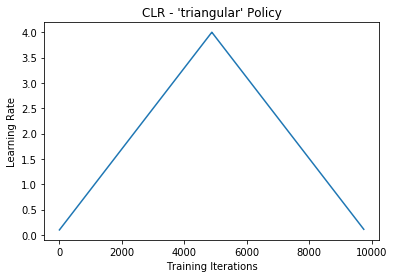

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [19]:
# Test the model - 1st time with reduced image size
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 7s 724us/step
Test loss: 0.7056791522026062
Test accuracy: 0.7815


In [20]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_50_epochs_size_16_channel_preprocess_sc.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
model.load_weights("DNST_model_50_epochs_size_16_channel_preprocess_sc.h5")
print("load model from disk")

load model from disk


In [22]:
# Load CIFAR10 Data - Original Size
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

mean_cifar10 = [125.3, 123.0, 113.9]
std_cifar10  = [63.0,  62.1,  66.7]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Perchannel normalization
def defnormalize_image_by_chanel(img):
    new_img = np.zeros(img.shape)
    mean_cifar10 = [125.3, 123.0, 113.9]
    std_cifar10  = [63.0,  62.1,  66.7]
    for i in range(3):
        new_img[:, :, i] = (img[:, :, i] - mean_cifar10[i]) / std_cifar10[i]
    return new_img

x_train = np.asarray([defnormalize_image_by_chanel(image) for image in x_train])
x_test = np.asarray([defnormalize_image_by_chanel(image) for image in x_test])




In [23]:
# determine Loss function and Optimizer
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])


In [24]:
batch_size = 128

clr_triangular = CyclicLR(base_lr=0.1, max_lr=4.0,step_size=9765, mode='triangular')


#May be near to https://arxiv.org/abs/1506.01186 (with a single cycle (a.k.a 1-Cycle policy)) using call backs. Need to try and then verify.
model.fit_generator(datagen_k.flow(x_train, y_train,  batch_size=batch_size), steps_per_epoch = np.ceil(len(x_train)//batch_size), verbose=1, epochs=epochs, validation_data=(x_test, y_test), callbacks=[clr_triangular])




Epoch 1/50
390/390 [==============================] - 210s 540ms/step - loss: 0.7798 - acc: 0.7291 - val_loss: 0.9331 - val_acc: 0.7315
Epoch 2/50
390/390 [==============================] - 142s 363ms/step - loss: 0.6785 - acc: 0.7669 - val_loss: 0.6295 - val_acc: 0.7981
Epoch 3/50
390/390 [==============================] - 140s 358ms/step - loss: 0.6423 - acc: 0.7804 - val_loss: 0.9330 - val_acc: 0.7483
Epoch 4/50
390/390 [==============================] - 140s 359ms/step - loss: 0.6244 - acc: 0.7859 - val_loss: 0.9481 - val_acc: 0.7500
Epoch 5/50
390/390 [==============================] - 139s 357ms/step - loss: 0.6156 - acc: 0.7916 - val_loss: 0.9485 - val_acc: 0.7327
Epoch 6/50
390/390 [==============================] - 139s 358ms/step - loss: 0.6182 - acc: 0.7912 - val_loss: 0.6718 - val_acc: 0.7988
Epoch 7/50
390/390 [==============================] - 140s 359ms/step - loss: 0.6236 - acc: 0.7885 - val_loss: 0.7562 - val_acc: 0.7747
Epoch 8/50
390/390 [============================

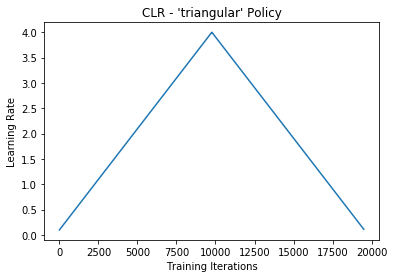

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [ ]:
# Test the model - 32x32 Image Size
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 10s 1ms/step
Test loss: 0.39074769403338433
Test accuracy: 0.8883


In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_50_epochs_size_32_channel_preprocess_sc.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

In [ ]:
from google.colab import files

files.download('DNST_model.h5')